# Evaluation of different classification algorithms for COVID-19 Pandemic Tweets

#### Stylianos Sidiropoulos (stysi607)

#### Text Mining (732A92) - Linköping University

## Load Libraries

In [65]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

## Data Preprocessing

keep only useful columns, check for nulls, check if dataset is balanced, balance dataset, lowercase words, remove stopwords, punctuations, numbers, links, hashtags, mentions etc.

Dataset: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

In [66]:
# Read data and merge it into one dataset
data = pd.read_csv("https://raw.githubusercontent.com/steliossid/covid19-classification/main/data.csv", encoding="latin")

not_whole_dataset = False

if not_whole_dataset:
    data = data.loc[:1000]
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [67]:
# Keep only OriginalTweet and Sentiment columns
data.pop("UserName")
data.pop("ScreenName")
data.pop("Location")
data.pop("TweetAt")
data.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [68]:
# Check if there are null values
data.isnull().values.any()

False

In [69]:
data.shape

(44955, 2)

In [70]:
sentiments = data.Sentiment.unique().tolist()
sentiments

['Neutral', 'Positive', 'Extremely Negative', 'Negative', 'Extremely Positive']

### Balance Dataset

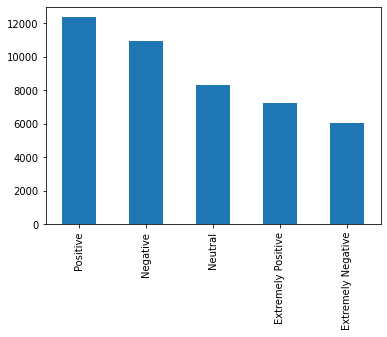

In [71]:
data.Sentiment.value_counts().plot(kind='bar');

In [72]:
data.Sentiment.value_counts()

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

Dataset is not balanced. (should I balance it?)

In [73]:
# Balance dataset
count_min = data.Sentiment.value_counts().min()

# Divide by class and Random undersampling without replacement
df_Pos = data[data.Sentiment == "Positive"].sample(count_min)
df_Neg = data[data.Sentiment == "Negative"].sample(count_min)
df_Neu = data[data.Sentiment == "Neutral"].sample(count_min)
df_ExPos = data[data.Sentiment == "Extremely Positive"].sample(count_min)
df_ExNeg = data[data.Sentiment == "Extremely Negative"]

data_balanced = pd.concat([df_Pos, df_Neg, df_Neu, df_ExPos, df_ExNeg], axis=0)

In [74]:
data_balanced.Sentiment.value_counts()

Positive              6073
Extremely Positive    6073
Neutral               6073
Extremely Negative    6073
Negative              6073
Name: Sentiment, dtype: int64

### Natural Language Processing (NLP)

In [75]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])

def preprocess(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc if not token.is_stop and token.lemma_.isalpha() and len(token)>2]

In [76]:
data_balanced["ProcessedTweet"] = data_balanced["OriginalTweet"].apply(lambda x: ' '.join(preprocess(x)))
data_balanced.head()

,OriginalTweet,Sentiment,ProcessedTweet
42264,"@SadhguruJV Saar, @SriSri Sir @yogrishiramdev ...",Positive,saar sir look gyaan guy speak economy value in...
37373,Decided to wear a handmade mask to go to the g...,Positive,decided wear handmade mask grocery store like ...
4890,Book Your Same Day Cleaning Today!\r\r\nServic...,Positive,book day cleaning today services las vegas hen...
9614,JPM: \r\r\n-Sales in the top 40 Chinese cities...,Positive,jpm chinese city week total unit coronavirus o...
22728,Due to plunging oil prices globally and the CO...,Positive,plunge oil price globally pandemic india plan ...


Some rows do not include anything after text processing, so we exclude them

In [77]:
is_empty = data_balanced.ProcessedTweet==""
data_balanced = data_balanced[is_empty==False]

Minor change in the balance of the classes, no need to rebalance the classes

In [78]:
data_balanced.Sentiment.value_counts()

Positive              6073
Extremely Positive    6073
Extremely Negative    6073
Negative              6072
Neutral               6040
Name: Sentiment, dtype: int64

In [80]:
data = data_balanced.copy()
data.shape

(30331, 3)

## Statistics

### Number of words in tweet

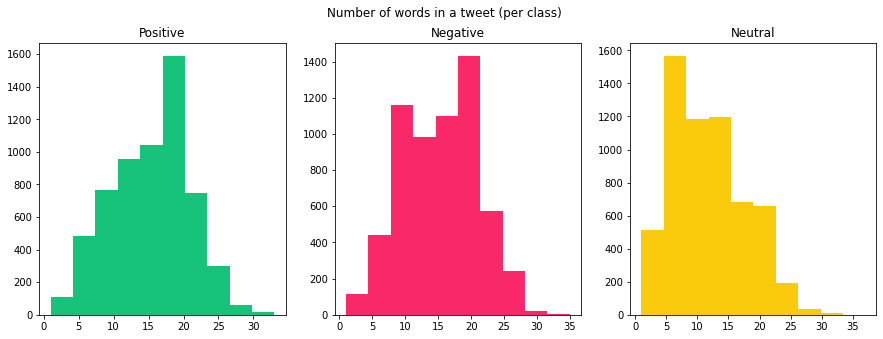

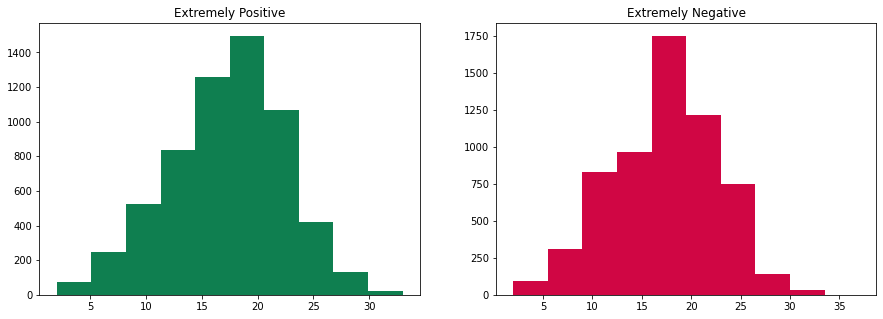

In [81]:
fig1,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
fig2,(ax4, ax5)=plt.subplots(1,2,figsize=(15,5))

len_pos = data[data['Sentiment']=="Positive"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax1.hist(len_pos, color='#17C37B')
ax1.set_title('Positive')

len_neg = data[data['Sentiment']=="Negative"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax2.hist(len_neg, color='#F92969')
ax2.set_title('Negative')

len_neu = data[data['Sentiment']=="Neutral"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax3.hist(len_neu, color='#FACA0C')
ax3.set_title('Neutral')

len_expos = data[data['Sentiment']=="Extremely Positive"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax4.hist(len_expos, color='#0f7f50')
ax4.set_title('Extremely Positive')

len_exneg = data[data['Sentiment']=="Extremely Negative"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax5.hist(len_exneg, color='#d00644')
ax5.set_title('Extremely Negative')

fig1.suptitle('Number of words in a tweet (per class)')
plt.show()

### Wordclouds

In [82]:
def create_wordlist(sentiment):
    wordlist=[]
    words_removed = ["coronavirus", "coronaviru", "covid19", "covid-19", "covid", "amp"]
    for line in data[data["Sentiment"]==sentiment]["ProcessedTweet"].str.split():
        for word in line:
            if word not in words_removed:
                wordlist.append(word)
    return wordlist

def create_wordcloud(sentiment):
    wordcloud = WordCloud().generate(" ".join(words for words in create_wordlist(sentiment)))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(sentiment + " " + "wordcloud")
    plt.show()

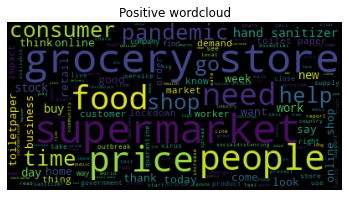

In [83]:
create_wordcloud("Positive")

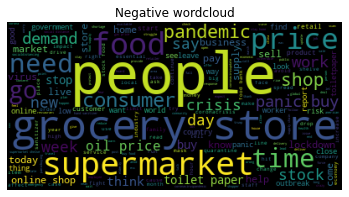

In [84]:
create_wordcloud("Negative")

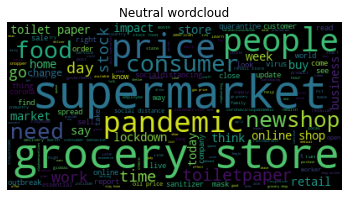

In [85]:
create_wordcloud("Neutral")

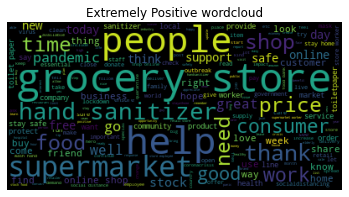

In [86]:
create_wordcloud("Extremely Positive")

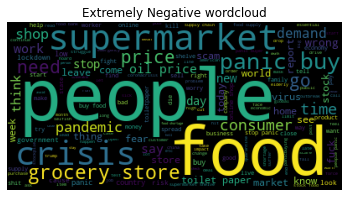

In [87]:
create_wordcloud("Extremely Negative")

In [88]:
def most_common_ngrams(sentiment, n_gram=1, n_common=10):
    wordlist = create_wordlist(sentiment)
    ngrams = zip(*[wordlist[i:] for i in range(n_gram)])
    counter = Counter(' '.join(ngram) for ngram in ngrams)
    return counter.most_common(n_common)

### Uni-grams

In [89]:
most_common_ngrams("Positive")

[('store', 1316),
 ('supermarket', 1144),
 ('grocery', 1107),
 ('price', 1091),
 ('food', 999),
 ('shop', 807),
 ('people', 758),
 ('consumer', 755),
 ('online', 607),
 ('need', 537)]

In [90]:
most_common_ngrams("Negative")

[('price', 1493),
 ('food', 1424),
 ('store', 1150),
 ('supermarket', 1136),
 ('grocery', 991),
 ('people', 920),
 ('shop', 680),
 ('buy', 645),
 ('consumer', 621),
 ('panic', 617)]

In [91]:
most_common_ngrams("Neutral")

[('store', 1315),
 ('supermarket', 1103),
 ('grocery', 1009),
 ('price', 916),
 ('consumer', 856),
 ('shop', 688),
 ('food', 611),
 ('online', 559),
 ('people', 508),
 ('pandemic', 440)]

In [92]:
most_common_ngrams("Extremely Positive")

[('store', 1420),
 ('grocery', 1097),
 ('food', 1056),
 ('help', 1054),
 ('supermarket', 1043),
 ('hand', 1014),
 ('shop', 922),
 ('price', 881),
 ('sanitizer', 844),
 ('people', 812)]

In [93]:
most_common_ngrams("Extremely Negative")

[('food', 1875),
 ('price', 1627),
 ('panic', 1460),
 ('people', 1437),
 ('supermarket', 1110),
 ('buy', 1096),
 ('store', 1006),
 ('crisis', 885),
 ('grocery', 809),
 ('shop', 639)]

### Bi-grams

In [94]:
most_common_ngrams("Positive", n_gram=2)

[('grocery store', 828),
 ('hand sanitizer', 343),
 ('online shop', 238),
 ('toilet paper', 191),
 ('social distance', 99),
 ('stay home', 98),
 ('oil price', 87),
 ('panic buy', 83),
 ('store worker', 81),
 ('retail store', 80)]

In [95]:
most_common_ngrams("Negative", n_gram=2)

[('grocery store', 762),
 ('panic buy', 313),
 ('oil price', 240),
 ('toilet paper', 221),
 ('online shop', 205),
 ('food bank', 109),
 ('stock food', 103),
 ('hand sanitizer', 96),
 ('social distance', 94),
 ('supermarket shelve', 93)]

In [96]:
most_common_ngrams("Neutral", n_gram=2)

[('grocery store', 776),
 ('toilet paper', 222),
 ('online shop', 212),
 ('social distance', 98),
 ('consumer behavior', 86),
 ('oil price', 84),
 ('retail store', 84),
 ('stock food', 73),
 ('stay home', 63),
 ('shop online', 61)]

In [97]:
most_common_ngrams("Extremely Positive", n_gram=2)

[('grocery store', 875),
 ('hand sanitizer', 640),
 ('online shop', 238),
 ('stay safe', 172),
 ('toilet paper', 155),
 ('stay home', 136),
 ('store worker', 121),
 ('shop online', 111),
 ('social distance', 105),
 ('wash hand', 104)]

In [98]:
most_common_ngrams("Extremely Negative", n_gram=2)

[('panic buy', 694),
 ('grocery store', 620),
 ('oil price', 290),
 ('toilet paper', 240),
 ('buy food', 148),
 ('stop panic', 137),
 ('online shop', 122),
 ('supermarket shelve', 115),
 ('food supply', 114),
 ('supply chain', 110)]

## Models

In [99]:
# Split train, test
X = data.ProcessedTweet
#X = data.OriginalTweet
y = data.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Vectorizer
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

def print_results(model):
  model.fit(X_train, y_train)
  y_predicted = model.predict(X_test)
  print(classification_report(y_test, y_predicted))

### Multinomial Naive Bayes

In [106]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', MultinomialNB())
])

parameters = {
    "predictor__alpha": (0.1, 1)
}

grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', MultinomialNB(alpha=grid_search.best_params_["predictor__alpha"]))
])

print_results(model)

Grid Search Best Score: 0.48804373379972416
predictor__alpha: 1
                    precision    recall  f1-score   support

Extremely Negative       0.53      0.75      0.62      1521
Extremely Positive       0.55      0.71      0.62      1587
          Negative       0.39      0.31      0.35      1502
           Neutral       0.67      0.45      0.54      1485
          Positive       0.37      0.29      0.33      1488

          accuracy                           0.51      7583
         macro avg       0.50      0.50      0.49      7583
      weighted avg       0.50      0.51      0.49      7583



### Logistic Regression

In [112]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', LogisticRegression(max_iter=10000))
])

parameters = {
    "predictor__penalty": ("l1", "l2")
}

grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', LogisticRegression(penalty=grid_search.best_params_["predictor__penalty"],
                                      max_iter=10000))
])

print_results(model)

Grid Search Best Score: 0.5428172741744957
predictor__penalty: 'l2'
                    precision    recall  f1-score   support

Extremely Negative       0.63      0.74      0.68      1521
Extremely Positive       0.64      0.74      0.69      1587
          Negative       0.44      0.33      0.38      1502
           Neutral       0.58      0.71      0.63      1485
          Positive       0.44      0.30      0.36      1488

          accuracy                           0.57      7583
         macro avg       0.55      0.56      0.55      7583
      weighted avg       0.55      0.57      0.55      7583



### Random Forest Classifier

In [113]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', RandomForestClassifier())
])

parameters = {
    "predictor__max_depth": (1,5,10,50),
    "predictor__n_estimators": (5,10,100,500)
}

grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', RandomForestClassifier(max_depth=grid_search.best_params_["predictor__max_depth"], 
                                         n_estimators=grid_search.best_params_["predictor__n_estimators"],
                                         class_weight="balanced"))
])

print_results(model)

Grid Search Best Score: 0.48289965914498784
predictor__max_depth: 50
predictor__n_estimators: 500
                    precision    recall  f1-score   support

Extremely Negative       0.65      0.65      0.65      1521
Extremely Positive       0.64      0.66      0.65      1587
          Negative       0.48      0.20      0.28      1502
           Neutral       0.39      0.89      0.54      1485
          Positive       0.48      0.13      0.20      1488

          accuracy                           0.51      7583
         macro avg       0.53      0.51      0.47      7583
      weighted avg       0.53      0.51      0.47      7583



### Decision Tree Classifier


very sloooow!

In [ ]:
# Find optimal parameters
# model = Pipeline([
#     ('vectorizer', tfidf_vectorizer),
#     ('predictor', DecisionTreeClassifier())
# ])

# parameters = {
#     "predictor__criterion": ("gini", "entropy"),
#     "predictor__max_depth": range(1,10),
#     "predictor__min_samples_split": range(1,10),
#     "predictor__min_samples_leaf": range(1,5),
# }


# grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
# grid_search = grid_search.fit(X_train, y_train)

# print("Grid Search Best Score: " + str(grid_search.best_score_))

# for param_name in sorted(parameters.keys()):
#     print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# # Using optimal parameters
# model = Pipeline([
#     ('vectorizer', tfidf_vectorizer),
#     ('predictor', DecisionTreeClassifier(criterion=grid_search.best_params_["predictor__criterion"],
#                                          max_depth=grid_search.best_params_["predictor__max_depth"],
#                                          min_samples_split=grid_search.best_params_["predictor__min_samples_split"],
#                                          min_samples_leaf=grid_search.best_params_["predictor__min_samples_leaf"],
#                                          class_weight="balanced"))
# ])

# print_results(model)

### Linear Support Vector Classifier (SVC)

In [116]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', LinearSVC(max_iter=10000))
])

parameters = {
    "predictor__penalty": ("l1", "l2")
}


grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', LinearSVC(penalty=grid_search.best_params_["predictor__penalty"],
                            class_weight="balanced", max_iter=10000))
])

print_results(model)

Grid Search Best Score: 0.5575440369698448
predictor__penalty: 'l2'
                    precision    recall  f1-score   support

Extremely Negative       0.62      0.79      0.70      1521
Extremely Positive       0.64      0.81      0.71      1587
          Negative       0.45      0.31      0.37      1502
           Neutral       0.64      0.67      0.65      1485
          Positive       0.44      0.30      0.36      1488

          accuracy                           0.58      7583
         macro avg       0.56      0.58      0.56      7583
      weighted avg       0.56      0.58      0.56      7583



### Stochastic Gradient Descent (SGD) Classifier

In [114]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', SGDClassifier())
])

parameters = {
    "predictor__alpha": (0.0001, 0.001, 0.01, 0.1, 1),
    "predictor__penalty": ("l1", "l2")
}

grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', SGDClassifier(alpha=grid_search.best_params_["predictor__alpha"], 
                                penalty=grid_search.best_params_["predictor__penalty"],
                                class_weight="balanced"))
])

print_results(model)

Grid Search Best Score: 0.5507301157844134
predictor__alpha: 0.0001
predictor__penalty: 'l2'
                    precision    recall  f1-score   support

Extremely Negative       0.56      0.87      0.68      1521
Extremely Positive       0.58      0.87      0.69      1587
          Negative       0.50      0.20      0.28      1502
           Neutral       0.62      0.70      0.66      1485
          Positive       0.49      0.17      0.25      1488

          accuracy                           0.57      7583
         macro avg       0.55      0.56      0.51      7583
      weighted avg       0.55      0.57      0.52      7583



### Extreme Gradient Boosting Classifier (XGB)

very sloooow!

In [ ]:
# # Find optimal parameters
# model = Pipeline([
#     ('vectorizer', tfidf_vectorizer),
#     ('predictor', XGBClassifier())
# ])

# parameters = {
#     "predictor__learning_rate": (0.0001, 0.001, 0.01, 0.1),
#     "predictor__max_depth": (1,3,5,7),
#     "predictor__no_estimators": (5,10,100,500)
# }

# grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
# grid_search = grid_search.fit(X_train, y_train)

# print("Grid Search Best Score: " + str(grid_search.best_score_))

# for param_name in sorted(parameters.keys()):
#     print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# # Using optimal parameters
# model = Pipeline([
#     ('vectorizer', tfidf_vectorizer),
#     ('predictor', XGBClassifier(learning_rate=grid_search.best_params_["predictor__learning_rate"], 
#                                 max_depth=grid_search.best_params_["predictor__max_depth"],
#                                 no_estimators=grid_search.best_params_["predictor__no_estimators"]))
# ])

# print_results(model)